# Day 10 Analysis

Day 10 is a continuation of Day 9's analysis of using mean regression to identify "buy low" and "sell high" candidates for fantasy football. Yesterday I focused on standard fantasy points. However, the PPR (1 point per reception) is a popular scoring system. The difference is that a player is given a point for every reception. It's a way to close the scoring gap between WRs and RBs.

Today I'll search for these players likely to regress to the mean but now I'm focusing on PPR points. Will the same players show up?

## Set Up

In [151]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import dataframe_image as dfi

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Target Share vs. PPR Fantasy Points: 1999-2011
First I'll get the average target share and PPR fantasy points scored by WR for seasons 1999-2021. Then I'll fit a regression line to the data which will be used to generate expected PR fantasy points for the 2022 season.

### Get Data

In [152]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season <> 2022
), aggregation AS (
    SELECT
        player_name,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_by_player_1999_2021 = pd.read_sql(query, conn)
print(df_by_player_1999_2021.shape)
df_by_player_1999_2021.head()


(1170, 4)


,player_name,num_games,avg_tgt_share,avg_pts_ppr
0,Derrick Alexander,52,0.199942,10.526923
1,Brian Alford,2,0.057958,3.850000
2,Reidel Anthony,36,0.121562,4.411111
3,Justin Armour,14,0.173866,7.371429
4,Karsten Bailey,9,0.076829,2.644444


### Clean Data

In [153]:
# Check for number of games played
# If number of game played = 1, can create noise. Will want to remove
print(df_by_player_1999_2021['num_games'].value_counts(normalize=True).sort_index()[:4].sum())
df_by_player_1999_2021['num_games'].value_counts(normalize=True).sort_index()[:10]

0.23333333333333334


1     0.096581
2     0.058974
3     0.045299
4     0.032479
5     0.025641
6     0.021368
7     0.029915
8     0.024786
9     0.015385
10    0.013675
Name: num_games, dtype: float64

I'll remove players with only 1 game played since those can definitely create some noise in the data. Based on normalized values I'd like to take players that have at least 5 games played but that would mean removing almost 25% of the data so I'll leave players with 2+ games in the dataset.

In [154]:
df_by_player_1999_2021 = df_by_player_1999_2021[df_by_player_1999_2021['num_games'] > 1]
print(df_by_player_1999_2021.shape)

(1057, 4)


### Exploratory Analysis

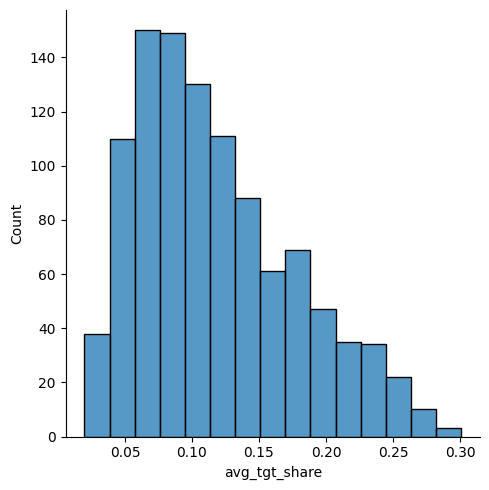

In [155]:
# Check distribution
sns.displot(
    x="avg_tgt_share",
    data=df_by_player_1999_2021,
    kind="hist",
    bins = 15
)

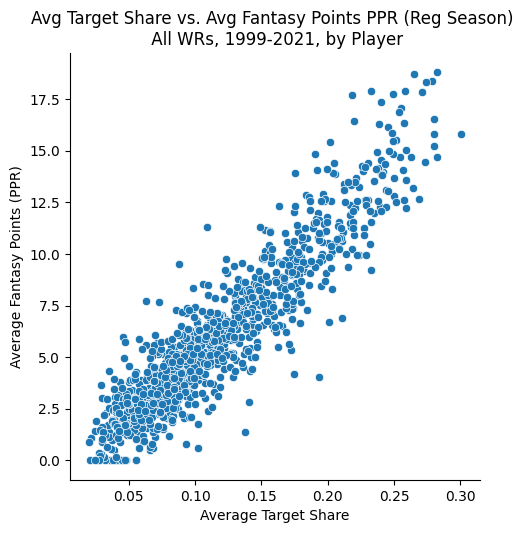

In [156]:
g = sns.relplot(
    x="avg_tgt_share",
    y="avg_pts_ppr",
    data=df_by_player_1999_2021
)

g.set(
    xlabel="Average Target Share", 
    ylabel="Average Fantasy Points (PPR)",
    title="Avg Target Share vs. Avg Fantasy Points PPR (Reg Season) \n All WRs, 1999-2021, by Player"
)

In [157]:
print(f"Correlation Coefficient: {df_by_player_1999_2021['avg_tgt_share'].corr(df_by_player_1999_2021['avg_pts_ppr'])}")

Correlation Coefficient: 0.9220525980482231


### Run Regression

In [158]:
# Fit a regression line
fit = np.polyfit(
    x=df_by_player_1999_2021['avg_tgt_share'], 
    y=df_by_player_1999_2021['avg_pts_ppr'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

In [159]:
# Use regression equation to get expected fantasy points for the 2022 season

# Get data
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        target_share AS tgt_share,
        fantasy_points_ppr AS pts_ppr
    FROM weekly 
    WHERE position = 'WR'
        AND season_type = 'REG'
        AND target_share IS NOT NULL -- There are data errors where target share was recorded as NULL, these can be removed
        AND season = 2022
), aggregation AS (
    SELECT
        player_name,
        COUNT(*) AS num_games,
        AVG(tgt_share) AS avg_tgt_share,
        AVG(pts_ppr) AS avg_pts_ppr
    FROM data
    GROUP BY player_id, player_name
)
SELECT *
FROM aggregation
"""

df_by_player_2022 = pd.read_sql(query, conn)

# Create summary table
summary_2022 = df_by_player_2022.sort_values('avg_pts_ppr', ascending=False).reset_index(drop=True) # index = fantasy points ranking
summary_2022.index = summary_2022.index + 1 # easier to read (1 is now top player by avg fantasy points)

summary_2022 = summary_2022.sort_values('avg_tgt_share', ascending=False)

summary_2022['avg_pts_expected'] = lin_func_fpts(summary_2022['avg_tgt_share'])
summary_2022['avg_pts_diff'] = summary_2022['avg_pts_ppr'] - summary_2022['avg_pts_expected']

print(summary_2022.shape)
summary_2022.head(10).round(3)


(196, 6)


,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
1,DeAndre Hopkins,2,0.393,27.100,22.290,4.810
20,CeeDee Lamb,8,0.328,14.600,18.472,-3.872
3,Cooper Kupp,7,0.325,24.529,18.290,6.238
4,Tyreek Hill,8,0.321,22.450,18.097,4.353
7,A.J. Brown,7,0.318,19.271,17.915,1.356
11,Davante Adams,7,0.297,17.014,16.633,0.381
34,D.J. Moore,8,0.290,12.175,16.272,-4.097
5,Justin Jefferson,7,0.290,21.203,16.264,4.939
2,Stefon Diggs,7,0.287,24.771,16.094,8.677
53,Drake London,8,0.280,9.825,15.676,-5.851


Based on the regression line fit on 1999-2021, CeeDee Lamb is scoring 3.9 PPR fantasy points less than he should be, per week – a good candidate for positive regression given his extremely high target share. Stefon Diggs is scoring 8.7 PPR fantasy points more than he should be, per week – a good candidate for negative regression. He is scoring much more than would be expected given his target share.

To see how likely it is for a player to regress to the mean, I will look at the distribution of `avg_points_diff` and if normal, will use statistical methods to determine probability.

In [161]:
# Sort by the difference between actual points and expected points to get the true "regression to the mean" candidates
# Remove players with only 1 game played as that can be considered noise
summary_2022[summary_2022['num_games'] > 1] \
    .sort_values('avg_pts_diff') \
    .head(10) \
    .round(3)

,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
76,Darnell Mooney,8,0.273,7.675,15.258,-7.583
53,Drake London,8,0.280,9.825,15.676,-5.851
109,Equanimeous St. Brown,7,0.196,5.271,10.722,-5.451
77,Robert Woods,7,0.231,7.657,12.762,-5.105
143,Marcus Johnson,4,0.143,3.075,7.586,-4.511
45,Diontae Johnson,8,0.265,10.550,14.756,-4.206
34,D.J. Moore,8,0.290,12.175,16.272,-4.097
20,CeeDee Lamb,8,0.328,14.600,18.472,-3.872
94,Michael Gallup,5,0.186,6.300,10.089,-3.789
38,Sterling Shepard,3,0.272,11.467,15.174,-3.707


Darnell Mooney is the standout here. With almost 27% of his team's target share in 2022 he's scoring about 7.6 standard fantasy points less per game than he "should be" based on the observed relationship between target share and fantasy points. 

## Analyze Average Points Differential

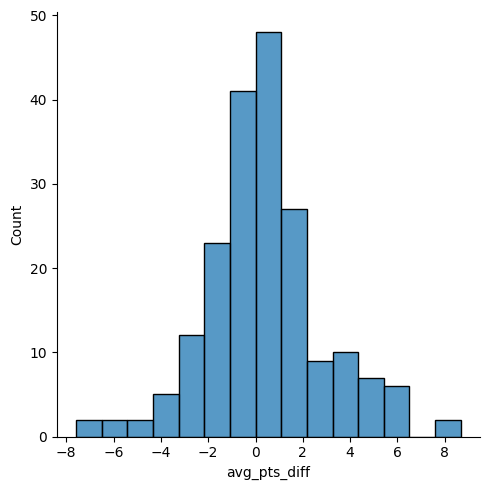

In [162]:
sns.displot(
    x='avg_pts_diff',
    data=summary_2022,
    kind="hist",
    bins=15
)

The distribution looks like a normal distribution with mean around 0. Next I'll get average points differential on the 1999-2021 population to confirm.

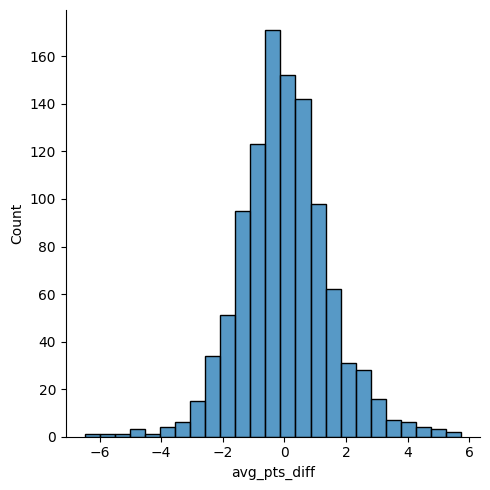

In [163]:
# Use regression line on original dataset with all values 
df_by_player_1999_2021['avg_pts_expected'] = lin_func_fpts(df_by_player_1999_2021['avg_tgt_share'])
df_by_player_1999_2021['avg_pts_diff'] = df_by_player_1999_2021['avg_pts_ppr'] - df_by_player_1999_2021['avg_pts_expected']

sns.displot(
    x='avg_pts_diff',
    data=df_by_player_1999_2021,
    kind="hist",
    bins=25
)

The population distribution confirms that average points differential is normally distributed with a mean of approximately 0.

In [164]:
summary_2022['avg_pts_diff'].describe()

count    196.000000
mean       0.379490
std        2.510342
min       -7.583270
25%       -0.926560
50%        0.286769
75%        1.725768
max        8.677129
Name: avg_pts_diff, dtype: float64

In [165]:
df_by_player_1999_2021['avg_pts_diff'].describe().apply(lambda x: format(x, 'f'))

count    1057.000000
mean       -0.000000
std         1.455056
min        -6.486032
25%        -0.868807
50%        -0.069934
75%         0.813049
max         5.734570
Name: avg_pts_diff, dtype: object

The observed expected points differential from 1999-2021 is normally distributed with a mean of 0 and standard deviation of 1.455. Therefore we would expect the sample population of player averages for 2022 to be normally distributed as well and thus we should be able to compute the likelihood of a player finishing with that expected point differential (actual - expected) using statistical methods. 

In [166]:
def cdf_player_2022(df, player_name):
    cdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).cdf(df[df['player_name'] == player_name]['avg_pts_diff'])
    return round((cdf[0] * 100),2)

def pdf_player_2022(df, player_name):
    pdf = scipy.stats.norm(
            df['avg_pts_diff'].mean(),
            df['avg_pts_diff'].std()
            ).pdf(df[df['player_name'] == player_name]['avg_pts_diff'])
    return round((pdf[0] * 100),2)

The pdf function calculates the probability of X for a given value of X. In this case, we are looking at the probability of a player having an average points differential of X for a given value of X (target share).

In [167]:
pdf_player_2022(summary_2022, 'CeeDee Lamb')

3.79

Going back to CeeDee lamb, using the normal distribution of average points differential, we are able to calculate that there is a 3.8% chance of scoring 3.9 points less than expected per week given his nearly 33% target share. If this is the case, CeeDee is a great "buy low", positive regression candidate and should be due for a more productive second half of the season.

In [168]:
pdf_player_2022(summary_2022, 'Stefon Diggs')

0.07

There is a .07% chance of Stefon Diggs scoring 8.7 PPR points more than expected per week. Wow! Let's explore that further and see if that probability makes sense. Looking first at player career stats.

In [169]:
# Show the average PPR points outperformers 
top_tgt_share_1999_2021 = df_by_player_1999_2021.sort_values('avg_tgt_share', ascending=False).reset_index(drop=True)
top_tgt_share_1999_2021.index = top_tgt_share_1999_2021.index + 1

print("Historical Data 1999 - 2021: Career averages with more than 10 games played")
top_tgt_share_1999_2021[top_tgt_share_1999_2021['num_games'] >= 10] \
    .sort_values('avg_pts_diff', ascending=False) \
    .round(3) \
    .head(10)

Historical Data 1999 - 2021: Career averages with more than 10 games played


,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
83,Tyreek Hill,91,0.219,17.713,12.043,5.671
56,Ja'Marr Chase,17,0.232,17.918,12.846,5.072
148,Marques Colston,142,0.191,14.828,10.394,4.434
116,Calvin Ridley,49,0.201,15.437,11.024,4.413
193,Chris Godwin,71,0.176,13.904,9.503,4.402
77,Deebo Samuel,37,0.220,16.429,12.120,4.309
45,Cooper Kupp,71,0.240,17.362,13.310,4.052
12,Antonio Brown,144,0.265,18.731,14.797,3.935
29,Calvin Johnson,135,0.249,17.760,13.846,3.914
973,Joseph Morgan,15,0.047,5.727,1.921,3.806


In [170]:
print("Seasons 1999 - 2021: Stefon Diggs")
top_tgt_share_1999_2021[top_tgt_share_1999_2021['player_name'] == 'Stefon Diggs'] \
    .round(3) \
    .head(10)

Seasons 1999 - 2021: Stefon Diggs


,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
32,Stefon Diggs,103,0.248,15.857,13.795,2.062


In [171]:
print("Current 2022 Season: Stefon Diggs")
summary_2022[summary_2022['player_name'] == 'Stefon Diggs'] \
    .head(10) \
    .round(3)

Current 2022 Season: Stefon Diggs


,player_name,num_games,avg_tgt_share,avg_pts_ppr,avg_pts_expected,avg_pts_diff
2,Stefon Diggs,7,0.287,24.771,16.094,8.677


Before the 2022 season, for his career, Stefon Diggs has an average target share of 25% and scores about 2 more PPR points per week than expected. Through the first 8 weeks of the 2022 season, Diggs has an average target share of 29% and scores about 8.7 more PPR points per week than expected. That's a 4.5x increase! Given a pretty large sample size of 103 games, I would expect this number to drop as the season goes on.

For tomorrow's analysis, I want to look at average point differential for player-season records. Yes, Diggs is performing much higher than expected over his career but perhaps other players have had these kinds of seasons before. Is it really that unlikely for Diggs to be performing this well?